In [ ]:
#!pip install pytube
#!pip install plotly

In [10]:
import os           

# Check if string is appropriate youtube link
import re
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from pytube import YouTube

import seaborn as sns
import plotly.express as px

# DEBUG-Mode stops operations when max_emotions were detected and also prints a short summary
DEBUG = True
if DEBUG:
    import time
    debug_params = {
        'max_emotions' : 1000
    }

In [15]:
def youtube_stream(yt_link):
    # Load the video from YouTube
    yt_video = YouTube(yt_link)
    stream = yt_video.streams.first()    #or highest resolution?
    stream.download()
    return cv2.VideoCapture(stream.default_filename)

def local_stream(local_path):
    return cv2.VideoCapture(local_path)

def get_stream(path):
    # Check if the string is a YouTube link
    if re.match(r'(https?://)?(www\.)?(youtube\.com|youtu\.?be)/.+$', path):
        return youtube_stream(path)
    # Check if the string is a local path
    elif os.path.isfile(path):
        return local_stream(path)
    # Check if the path is a local file path but no file is found
    elif os.path.exists(path):
        raise ValueError(f"File not found at path: {path}")
    # If it's neither a local path nor a YouTube link, raise an error
    else:
        raise ValueError("The input string is neither a local path nor a YouTube link.")
    
def preprocess_face(face_tensor, face_size):
    # Convert the face from a PyTorch tensor to a NumPy array
    face = face_tensor.permute(1, 2, 0).numpy()
    # Gray scale
    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    # Resize the face to the input size of the emotion detection model
    face = cv2.resize(face, face_size)
    # Normalize the pixel values
    face = face.astype('float32') / 255.0
    # Add a batch dimension to the face
    face = np.expand_dims(face, axis=0)
    return face
    
def get_ordered_emotions():
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def get_plottable_df(emotions, frame_info, frame_info_cols):

    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    df_plotting = pd.melt(df_all_info, id_vars=frame_info_cols, value_vars=get_ordered_emotions(), var_name='emotion', value_name='probability')
    return df_plotting

In [16]:
if DEBUG: start_time = time.time()

# Define video path
path = 'https://www.youtube.com/watch?v=CjVVNuraly8'        # random video
#path = 'https://www.youtube.com/watch?v=embYkODkzcs'        # 7 basic emotions
#path = '/Users/ben/neuefische/capstone/ai-with-python-series/07. Emotion Recognition using Live Video/content/Baseball Training.mp4'

# Get Video as cv2.VideoCapture
# Can access Youtube Video or local file
video = get_stream(path)

# Initialize the face detection model
face_detector = MTCNN(keep_all=True, post_process=False, margin=20)

# Initialize the emotion detection model
emotion_classifier = load_model("../models/emotion_model.hdf5", compile=False)

# Initialize lists to store emotions and frame_info
emotions = []
frame_info = []

# Set the frame rate and the number of frames to skip between each face detection
frame_rate = 30
skip_frames = int(video.get(cv2.CAP_PROP_FPS) / frame_rate)
frames_without_faces_counter = 0

# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Convert the frame from BGR to RGB color space
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces in the frame using the MTCNN model
    faces = face_detector(frame)

    # Check if any faces were found
    if faces is None:
        frames_without_faces_counter += 1
        continue
    
    # Extract the faces from the tensor and add them to the list
    for face in faces:
                
        # Preprocess individual face
        face_pp = preprocess_face(face_tensor = face, face_size = emotion_classifier.input_shape[1:3])

        # Predict the emotions for the face using the emotion detection model
        prob = emotion_classifier.predict(face_pp)[0]
        # Append to emotions list
        emotions.append(prob)
        
        # Add the current timestamp (milliseconds) and probabilities of emotions to the frame_description list
        frame_info.append((video.get(cv2.CAP_PROP_POS_MSEC),int(video.get(cv2.CAP_PROP_POS_FRAMES))))    # current implementation to prepare for tuple-wise operation, change frame later to character_nr

    if DEBUG:
        # For debugging reasons, we stop when we have 1000 emotion values
        if len(emotions) > debug_params['max_emotions']:
            break

# Release the video and close the window
video.release()

if DEBUG: end_time = time.time()

if DEBUG:
    # When in DEBUG-mode, print some statistics about the faces and emotions detected
    operating_results = {'analyzed_emotions': len(emotions),
                         'analyzed_frames':frame_info[-1][1], 
                         'frames_without_faces':frames_without_faces_counter,
                         'frames_without_faces_ratio': round(100*frames_without_faces_counter/frame_info[-1][1],2),
                         'processed_video_time': round(frame_info[-1][0] / 1000 ,2),
                         'runtime': round(end_time - start_time,2)}
    

    print(f'{operating_results["analyzed_emotions"]} faces found in {operating_results["analyzed_frames"]} frames.')
    print(f'{operating_results["frames_without_faces"]} frames had no face detected ({operating_results["frames_without_faces_ratio"]}%).')
    print(f'Stopped operations after around {operating_results["processed_video_time"]} seconds into the video.')
    print(f'Execution time: {operating_results["runtime"]} seconds, processing (roughly) {round(operating_results["processed_video_time"]/operating_results["runtime"],2)} seconds of video per second of execution')

df_plotting = get_plottable_df(emotions, frame_info, frame_info_cols=['pos_msec', 'frame'])

AttributeError: 'NoneType' object has no attribute 'span'

In [13]:
#df_10th = df_plotting[df_plotting["frame"] % 3 == 0]  # select every 10th frame

fig = px.bar(df_plotting, x="pos_msec", y='probability', color = 'emotion',
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)")
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",     title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [29]:
#df_10th = df_emotions[df_emotions["Frame"] % 20 == 0]  # select every 10th frame

# assuming your DataFrame is named df
fig = px.area(df_plotting, x="pos_msec", y='probability', color = 'emotion',
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion-Map")

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    yaxis=dict(
        title='Emotion distribution'
    ),
    xaxis=dict(
        title='Frame'
    ),
    title={
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

<Axes: xlabel='pos_msec', ylabel='probability'>

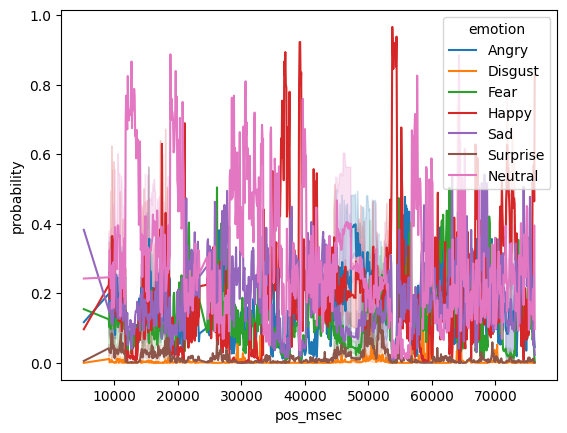

In [30]:
sns.lineplot(data = df_plotting, x = 'pos_msec', y='probability', hue = 'emotion')

In [31]:
fig = px.area(df_plotting, x="pos_msec", y="probability", color="emotion")
fig.show()

In [32]:
df = df_plotting
df['moving_avg'] = df['probability'].rolling(window=10, center=True).mean()

In [33]:
fig = px.area(df, x="pos_msec", y="moving_avg", color="emotion")
fig.show()

# I Adjusted plots until here

### Still Open
* Periods with no people are by now interlinked - so we have straight in the original data and valleys forming in the rolling mean.
* Tha Barcharts show quite well when multiple people com into play - but by now, their values are summed up. If we can get Character Recognition to work, that will be great - if not, at least we can try to reduce it down to one person per frame, but there's no guarantee that we always get the same person.
* With objects and classes we could structure the code even better
* I have the feeling from my videos that the performance is not super good right - maybe we achieve to get better results somehow.
* Much faster on youtube video data looking at Video_seconds analyzed per processing second.

#### After Dinner the youtube integration stopped working, I can't see why!

<Axes: xlabel='Frame', ylabel='moving_avg'>

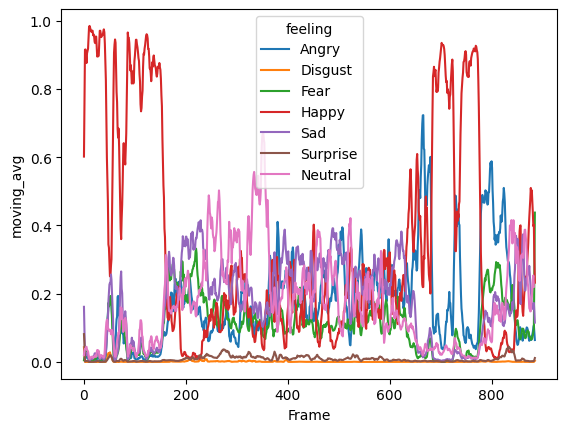

In [71]:
sns.lineplot(data = df_plotting, x = 'Frame', y='moving_avg', hue = 'feeling')

In [87]:
df_plotting

,Frame,feeling,probability,moving_avg
0,0,Angry,0.005274,NaN
1,1,Angry,0.010392,NaN
2,2,Angry,0.008759,NaN
3,3,Angry,0.028516,NaN
4,4,Angry,0.004002,NaN
...,...,...,...,...
6197,881,Neutral,0.185039,0.202502
6198,882,Neutral,0.252427,NaN
6199,883,Neutral,0.252427,NaN
6200,884,Neutral,0.240728,NaN


In [90]:
max_prob_rows = df_plotting.groupby('Frame')['probability'].idxmax().reset_index()
max_prob_df = df.loc[max_prob_rows['probability']]
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()
max_prob_df


,Frame,feeling,probability,moving_avg
2658,0,Happy,0.955532,0.505082
2659,1,Happy,0.935133,0.593292
2660,2,Happy,0.923429,0.665813
2661,3,Happy,0.822713,0.738803
2662,4,Happy,0.938086,0.825939
...,...,...,...,...
3539,881,Happy,0.507732,0.446257
3540,882,Happy,0.367060,0.402680
3541,883,Happy,0.367060,0.351637
3542,884,Happy,0.399157,0.299369


In [49]:
sns.barplot(data = max_prob_df, x = 'Frame', y='probability', hue='feeling')

NameError: name 'max_prob_df' is not defined

In [145]:
'''
# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# group by feeling and count unique frames
feeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()

# print top three probabilities for each frame
print(top_three_probs)
'''

"\n# sort dataframe by probability within each frame\nsorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])\n\n# get the top three probabilities for each frame\ntop_three_probs = sorted_df.groupby('frame').head(3)\n\n# group by feeling and count unique frames\nfeeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()\n\n# print top three probabilities for each frame\nprint(top_three_probs)\n"

In [28]:

# sort dataframe by probability within each frame
sorted_df = df.sort_values(['Frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('Frame').head(3)

# count the number of occurrences of each feeling for each frame
feeling_counts = top_three_probs.groupby(['Frame', 'feeling'])['probability'].count().reset_index()

# calculate the total probability for each frame
frame_total = feeling_counts.groupby('Frame')['probability'].sum().reset_index()

# merge the feeling counts and frame totals dataframes
merged = pd.merge(feeling_counts, frame_total, on='Frame', suffixes=('_count', '_total'))

# calculate the normalized distribution of each feeling for each frame
merged['probability_normalized'] = merged['probability_count'] / merged['probability_total']

# create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='Frame', 
    y='probability_normalized', 
    color='feeling', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Normalized Feeling Distribution',
    labels={
        'Frame': 'Frame',
        'probability_normalized': 'Probability',
        'feeling': 'Feeling'
    }
)

fig.show()


In [29]:
import plotly.graph_objs as go

# group the dataframe by feeling and count the number of unique frames for each feeling
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()

# create a bar chart with the feeling counts
data = go.Bar(x=feeling_counts.index, y=feeling_counts.values)

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings')

# create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [30]:
# create the data for the outer and inner rings
outer_data = go.Pie(labels=feeling_counts.index, values=feeling_counts.values, hole=0.45)
inner_data = go.Pie(labels=[''], values=[1], hole=1, marker=dict(colors=['white']))

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings', annotations=[{
            'text': 'Total frames: {}'.format(len(max_prob_df)),
            'font': {'size': 20},
            'showarrow': False,
            'x': 0.5,
            'y': 0.5
        }])

# create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()

In [31]:
categories = ["angry",
            "disgust",
            "fear",
            "happy",
            "sad",
            "surprise",
            "neutral"]
#values = [max_prob_df[max_prob_df['feeling'] == category]['frame'].nunique() for category in categories]

# Define the categories and values
#categories = feeling_counts.index
values = feeling_counts.values

# Create the radar chart
data = go.Scatterpolar(
    r = values,
    theta = categories,
    fill = 'toself',
    name = 'Prevalence of feelings'
)

# Set the layout for the chart
layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = False,
            range = [0, max(values)]
        )
    ),
    showlegend = False,
    title = 'Prevalence of feelings'
)

# Create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [150]:
from paz.pipelines import MiniXceptionFER

classify = MiniXceptionFER()

In [151]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

In [152]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

NameError: name 'results' is not defined

Old / not yet used

In [ ]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.